<div style="text-align:center;color:Blue">
    <h2> Graph Regression with Graph Neural Networks</h2>
</div>

#### This notebook presents a thorough approach on how to apply Graph Neural Networks (GNNs) to solve a graph regression problem. 

We apply graph regression to assign one y-value to an entire graph (in contrast to nodes). 
1. We start with a dataset of graphs, based on some structural graph properties - in today's case based on lipophilicity.
2. Accordingly, entire graphs are embedded in such a way that helps us predict a molecular property prediction (a single 
lipophilicity value) for each. One can use these embeddings further to do more analysis, such as 
to classify them based on a value, such as a lipophilicity range.

Play with the model settings, data splitting, training setups etc. to get the best results from this code and any other data/model you implement based on the information provided.

#### The data: Experimental results of octanol/water distribution coefficient (logD at pH 7.4). 
Lipophilicity is an important feature of drug molecules that affects both membrane permeability 
and solubility - thus a molecule's interactivity with other molecules. 

1.	Import lipophilicity data for 4000 molecules (https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv, or use Python)
2. from PyTorch Geometric’s dataset library (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)
   
This Lipophilicity dataset is curated from ChEMBL database, provides experimental results of 
octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds. 
Read more: https://arxiv.org/pdf/1703.00564.pdf

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader, Batch
from torch_geometric.datasets import MoleculeNet
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import KFold


<div style="text-align:center;color:Blue">
    <h3> Lipophilicty dataset import (load if already imported) and explore</h3>
</div>

In [12]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess dataset
dataset = MoleculeNet(root=".", name="lipo")

# Ensure proper data types
for data in dataset:
    data.x = data.x.float()
    data.y = data.y.float()

In [14]:
# Scaffold split function
def scaffold_split(dataset, k=5):
    scaffolds = []
    for smiles in dataset.smiles:
        mol = Chem.MolFromSmiles(smiles)
        scaffold = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)
        scaffolds.append(Chem.MolToSmiles(scaffold))
    
    unique_scaffolds = list(set(scaffolds))
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for train_idx, test_idx in kf.split(unique_scaffolds):
        train_scaffolds = [unique_scaffolds[i] for i in train_idx]
        train_mask = [s in train_scaffolds for s in scaffolds]
        test_mask = [not x for x in train_mask]
        
        train_dataset = dataset[train_mask]
        test_dataset = dataset[test_mask]
        
        yield train_dataset, test_dataset

In [15]:
# Get split datasets
train_dataset, test_dataset = next(scaffold_split(dataset))

In [16]:
# Model definition
class ImprovedGCN(nn.Module):
    def __init__(self, num_features):
        super(ImprovedGCN, self).__init__()
        
        self.conv1 = GCNConv(num_features, 128)
        self.bn1 = BatchNorm(128)
        self.drop1 = nn.Dropout(0.3)
        
        self.conv2 = GCNConv(128, 256)
        self.bn2 = BatchNorm(256)
        self.drop2 = nn.Dropout(0.3)
        
        self.conv3 = GCNConv(256, 512)
        self.bn3 = BatchNorm(512)
        self.drop3 = nn.Dropout(0.3)
        
        self.conv4 = GCNConv(512, 256)
        self.bn4 = BatchNorm(256)
        
        self.lin1 = nn.Linear(512, 128)
        self.lin2 = nn.Linear(128, 1)
        
    def forward(self, x, edge_index, batch_index):
        x = x.float()
        edge_index = edge_index.long()
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.drop1(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.drop2(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.drop3(x)
        
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        
        x1 = gmp(x, batch_index)
        x2 = gap(x, batch_index)
        x = torch.cat([x1, x2], dim=1)
        
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = self.lin2(x)
        
        return x, x

# Initialize model
num_features = dataset[0].x.shape[1]
model = ImprovedGCN(num_features).to(device)

In [17]:
# Data loaders with collate function
def collate_fn(batch):
    batch = Batch.from_data_list(batch)
    batch.x = batch.x.float()
    batch.y = batch.y.float()
    return batch

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Training setup
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)
loss_fn = nn.MSELoss()


In [18]:
# Training and evaluation functions
def train(model, loader):
    model.train()
    total_loss = 0
    preds, targets = [], []
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred, _ = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
        preds.append(pred.detach().cpu().numpy())
        targets.append(batch.y.detach().cpu().numpy())
    
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    
    return total_loss / len(loader.dataset), r2, mae, rmse

In [19]:
def test(model, loader):
    model.eval()
    total_loss = 0
    preds, targets = [], []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred, _ = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(pred, batch.y)
            
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.detach().cpu().numpy())
            targets.append(batch.y.detach().cpu().numpy())
    
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    r2 = r2_score(targets, preds)
    mae = mean_absolute_error(targets, preds)
    rmse = np.sqrt(mean_squared_error(targets, preds))
    
    return total_loss / len(loader.dataset), r2, mae, rmse

In [20]:
# Training loop
best_val_r2 = -np.inf
train_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}
val_history = {'loss': [], 'r2': [], 'mae': [], 'rmse': []}

for epoch in range(1, 1001):
    train_loss, train_r2, train_mae, train_rmse = train(model, train_loader)
    val_loss, val_r2, val_mae, val_rmse = test(model, test_loader)
    
    scheduler.step(val_loss)
    
    # Save history
    train_history['loss'].append(train_loss)
    train_history['r2'].append(train_r2)
    train_history['mae'].append(train_mae)
    train_history['rmse'].append(train_rmse)
    
    val_history['loss'].append(val_loss)
    val_history['r2'].append(val_r2)
    val_history['mae'].append(val_mae)
    val_history['rmse'].append(val_rmse)
    
    # Early stopping
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 100:
            print(f'Early stopping at epoch {epoch}')
            break
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch:03d}:')
        print(f'Train Loss: {train_loss:.4f} | R2: {train_r2:.4f} | MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f}')
        print(f'Val Loss: {val_loss:.4f} | R2: {val_r2:.4f} | MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f}\n')
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

Epoch 050:
Train Loss: 0.0005 | R2: 0.9999 | MAE: 0.0168 | RMSE: 0.0228
Val Loss: 0.0110 | R2: 0.9969 | MAE: 0.1028 | RMSE: 0.1048

Epoch 100:
Train Loss: 0.0003 | R2: 0.9999 | MAE: 0.0113 | RMSE: 0.0162
Val Loss: 0.0010 | R2: 0.9997 | MAE: 0.0280 | RMSE: 0.0317

Epoch 150:
Train Loss: 0.0005 | R2: 0.9999 | MAE: 0.0153 | RMSE: 0.0230
Val Loss: 0.0007 | R2: 0.9998 | MAE: 0.0200 | RMSE: 0.0262

Epoch 200:
Train Loss: 0.0003 | R2: 0.9999 | MAE: 0.0126 | RMSE: 0.0179
Val Loss: 0.0006 | R2: 0.9998 | MAE: 0.0229 | RMSE: 0.0240

Early stopping at epoch 203


<All keys matched successfully>

In [21]:
# Visualization functions
def plot_history(train_history, val_history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    metrics = ['loss', 'r2', 'mae', 'rmse']
    titles = ['Loss', 'R2 Score', 'MAE', 'RMSE']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        ax.plot(train_history[metric], label=f'Train {titles[i]}')
        ax.plot(val_history[metric], label=f'Val {titles[i]}')
        ax.set_title(titles[i])
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


In [22]:
import pandas as pd
def evaluate_and_plot(model, loader, title):
    model.eval()
    preds, targets, smiles = [], [], []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            p, _ = model(batch.x, batch.edge_index, batch.batch)
            preds.append(p.cpu().numpy())
            targets.append(batch.y.cpu().numpy())
            smiles.extend(batch.smiles)
    
    preds = np.concatenate(preds).reshape(-1)
    targets = np.concatenate(targets).reshape(-1)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(targets, preds, alpha=0.6)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    plt.title(f'{title} (R2: {r2_score(targets, preds):.3f})')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.savefig(f'{title.lower().replace(" ", "_")}_results.png')
    plt.show()
    
    return pd.DataFrame({'SMILES': smiles, 'True': targets, 'Predicted': preds})

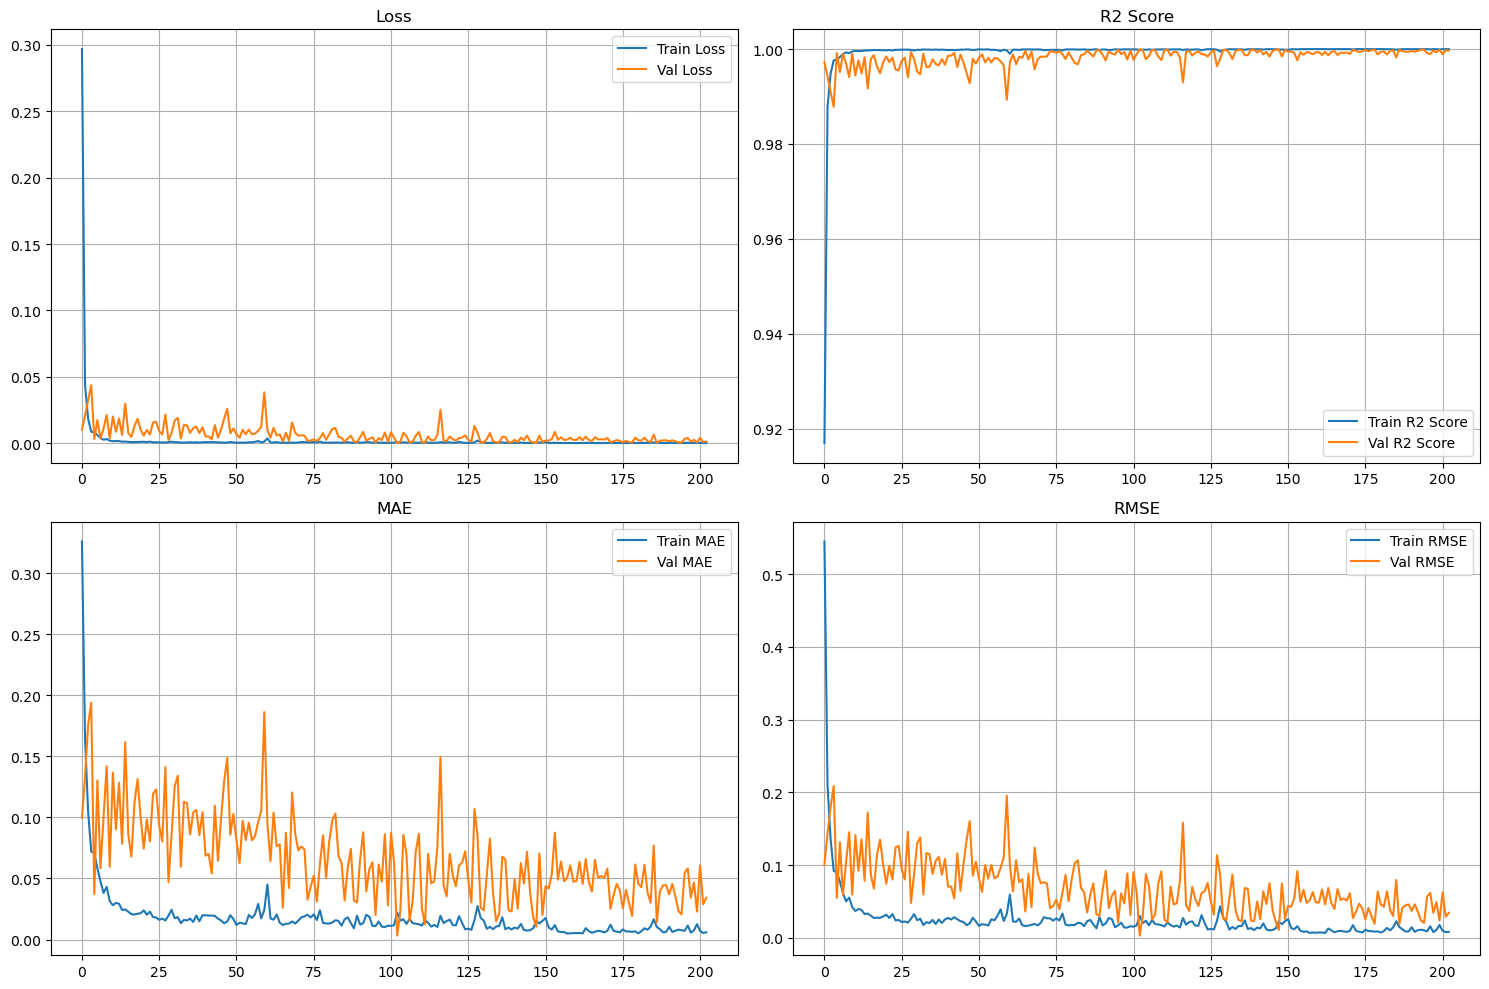

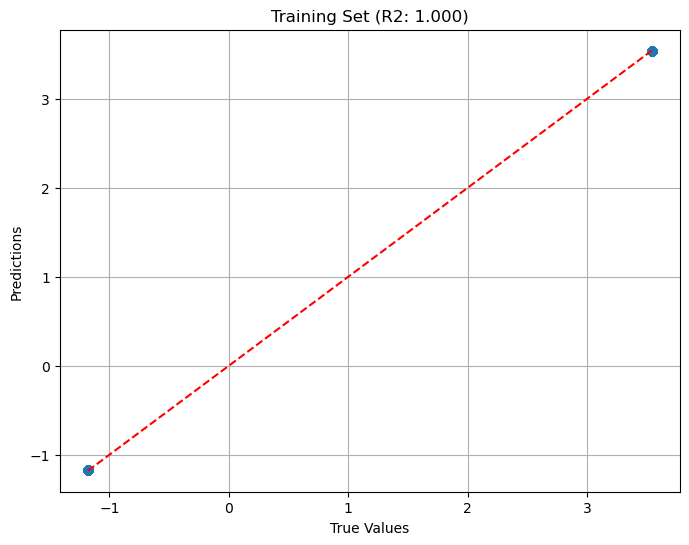

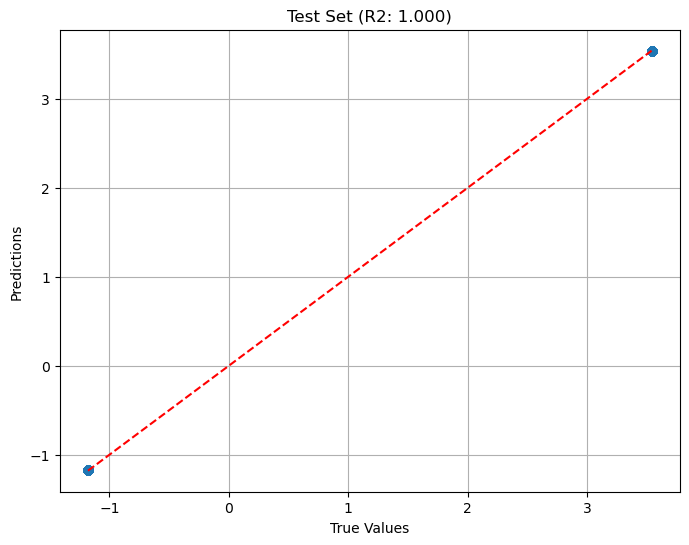

In [23]:
# Generate results
plot_history(train_history, val_history)
train_results = evaluate_and_plot(model, train_loader, 'Training Set')
test_results = evaluate_and_plot(model, test_loader, 'Test Set')


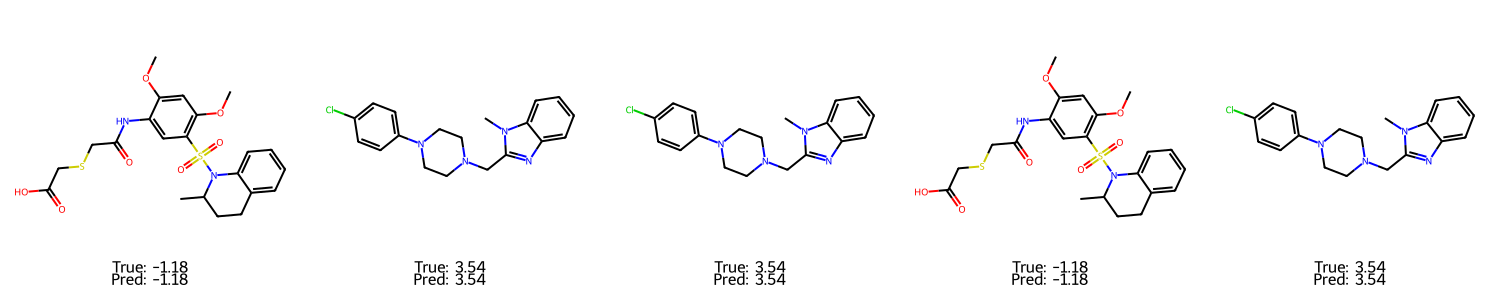

In [24]:
# Show some example molecules
def show_examples(results, n=5):
    sample = results.sample(n)
    mols = [Chem.MolFromSmiles(smi) for smi in sample['SMILES']]
    legends = [f"True: {t:.2f}\nPred: {p:.2f}" 
              for t, p in zip(sample['True'], sample['Predicted'])]
    
    img = Draw.MolsToGridImage(mols, molsPerRow=n, subImgSize=(300, 300), 
                            legends=legends, returnPNG=False)
    img.save('example_predictions.png')
    return img
show_examples(test_results)

## Prediction

In [27]:
import torch
from rdkit import Chem
from torch_geometric.data import Data
import rdkit.Chem.Descriptors as descriptors

# Load your trained model (modify as needed)
def load_model(model_path='best_model.pt'):
    model = torch.load(model_path)
    model.eval()
    return model

# Convert SMILES to PyG Data object with basic features
def smiles_to_data(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Basic atom features (customize with your actual features)
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetIsAromatic()
        ]
        atom_features.append(features)
    
    # Basic bond features
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.extend([[i, j], [j, i]])  # Undirected edges
        bond_type = bond.GetBondTypeAsDouble()
        edge_attr.extend([[bond_type], [bond_type]])
    
    if not edge_index:  # Handle single-atom molecules
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 1), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    x = torch.tensor(atom_features, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Prediction function
def predict(model, smiles):
    data = smiles_to_data(smiles)
    if data is None:
        return "Invalid SMILES string"
    
    # Create batch (single molecule)
    batch = torch.zeros(data.num_nodes, dtype=torch.long)
    
    with torch.no_grad():
        prediction, _ = model(data.x, data.edge_index, batch)
    
    return f"Predicted logD: {prediction.item():.2f}"

# Main interactive loop
def main():
    model = load_model()
    print("Molecular Property Predictor (type 'quit' to exit)")
    
    while True:
        smiles = input("\nEnter SMILES string: ").strip()
        if smiles.lower() in ['quit', 'exit', 'q']:
            break
        
        try:
            result = predict(model, smiles)
            print(result)
        except Exception as e:
            print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [3]:
print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)


======== Dataset =======

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset size (graphs):  4200
Dataset features:  9
Dataset target:  553
Dataset length:  <bound method InMemoryDataset.len of Lipophilicity(4200)>

======== first sample =======

Dataset sample:  Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Sample  nodes:  24
Sample  edges:  54


 <div style="text-align:left;color:Maroon">
    <h4> Take a look at the first 5 nodes from the first sample molecule</h4>
</div>

In [4]:
dataset[0].x[:5]

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 4, 0, 1]])

<div style="text-align:left;color:Maroon">
    <h4> The first 5 sparse matrices (COO)</h4>
</div>

In [5]:
dataset[0].edge_index.t()[:5]

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 1, 23],
        [ 2,  1]])

<div style="text-align:left;color:Maroon">
    <h4> The target (lipophilicty value for the first data point (i.e. molecule))</h4>
</div>

In [6]:
dataset[0].y

tensor([[3.5400]])

<div style="text-align:left;color:Maroon">
    <h4>Use pubchempy to get the name and rdkit to draw the first molecular structure</h4>
</div>

In [7]:
sm = dataset[0]['smiles']
compound = pubchempy.get_compounds(sm, namespace='smiles')
match = compound[0]
match.iupac_name

'2-[[4-(4-chlorophenyl)piperazin-1-yl]methyl]-1-methylbenzimidazole'

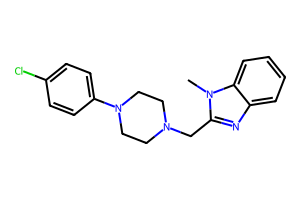

In [8]:
molecule = Draw.MolsToGridImage([Chem.MolFromSmiles(sm)], 
                molsPerRow=1, subImgSize=(300,200), returnPNG=False)
molecule.save('assets/images/first_molecule.png')
molecule

<div style="text-align:left;color:Maroon">
    <h4>Let's build a dataframe with some important attributes for each of the first 12 molecules. Twelve because it makes grid plotting easier. Here, we convert a tensor (the target, data.y) to an array for simplicity.</h4>
</div>

In [9]:
top_n = 12
data_attrib = []

for data in dataset[:top_n]:
    data_attrib.append([data.num_nodes, data.num_edges, data.smiles, np.array(data.y[0])[0]])
    
data_attr = pd.DataFrame(data_attrib)
data_attr.columns = ['num_nodes', 'num_edges', 'smiles', 'target_logD']
data_attr.head(top_n)

,num_nodes,num_edges,smiles,target_logD
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25


<div style="text-align:left;color:Maroon">
    <h4>Next, we plot the molecular structure for the first 12 molecules. We use the package 'pubchempy' to convert smiles into chemical names. Then we shorten the names for visual clarity (in subplot titles and the above dataframe). To do so, we split the name and use the last string piece after the last ')' or ']', whichever is the shortest.</h4>
</div>

In [10]:
ch_names = []
for i in data_attr["smiles"]:
    compounds = pubchempy.get_compounds(i, namespace='smiles')
    match = compounds[0]
    names = [match.iupac_name.split(')')[-1], match.iupac_name.split(']')[-1]]
    res = min(names, key=len)
    ch_names.append(res)
chem_names = ['... ' + str(i) for i in ch_names]
data_attr["name"] = chem_names
data_attr

,num_nodes,num_edges,smiles,target_logD,name
0,24,54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,... -1-methylbenzimidazole
1,33,70,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,... sulfanylacetic acid
2,21,46,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,... acetate
3,28,62,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,... pyrrole-5-carboxamide
4,28,58,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,... -2-methylpyrazole-3-carboxamide
5,23,52,OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4,3.14,... octan-3-ol
6,35,74,COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...,-0.72,... -4-oxobutanoic acid
7,34,72,CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...,0.34,... propanoic acid
8,23,50,COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O,3.05,... chromen-4-one
9,15,34,Oc1ncnc2scc(c3ccsc3)c12,2.25,... pyrimidin-4-one


<div style="text-align:left;color:Maroon">
    <h4>Save the dataframe as an image using a great python package called 'dataframe_image'</h4>
</div>

In [14]:
data_attr.to_csv("assets/data_attrib.csv", index=False)

In [16]:
import pandas as pd

# Load data from a CSV file
data_attr = pd.read_csv("/Users/sheenamittal/Downloads/GNNs_drug_discovery_regression-gnn_main/assets/data_attrib.csv")

# Apply styling and export
df_styled = data_attr.style.background_gradient()
dfi.export(df_styled, "assets/images/data_attrib.png", table_conversion='matplotlib')

<div style="text-align:left;color:Maroon">
    <h4>We are now ready to plot the 12 molecules</h4>
</div>

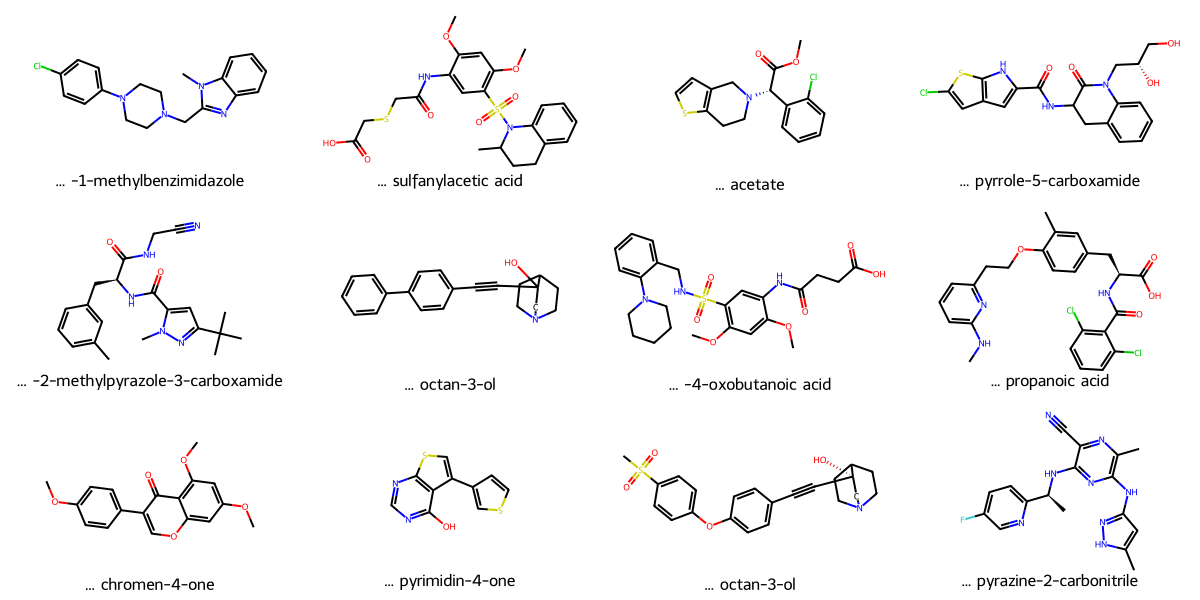

In [17]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles(data_attr["smiles"][i]) for i in range(top_n)], 
                         molsPerRow=4,subImgSize=(300,200), legends=list(data_attr.name.values),
                         returnPNG=False)
img.save('assets/images/molecules.png')
img

<div style="text-align:left;color:Maroon">
    <h4>To visualize two of the graphs (the first and tenth graph from our original dataset), we convert PyTorch Geometric graph to to NetworkX. Note that there are 24 nodes in the first graph and 27 in the second.</h4>
</div>

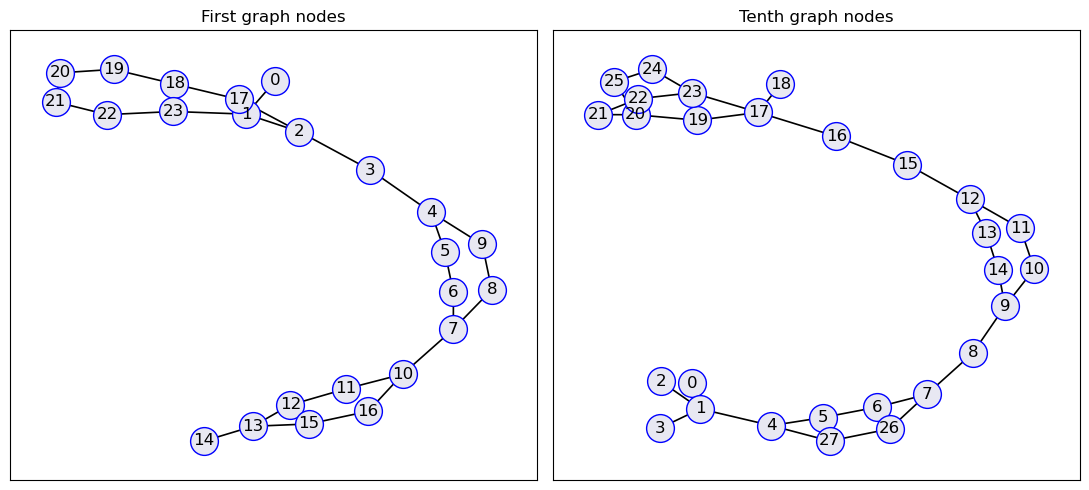

In [18]:
import matplotlib.pyplot as plt

def visualize_net():
    plt.figure(figsize=(11,5))
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0,0))
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0,1))
    ax1.set_title('First graph nodes')
    ax2.set_title('Tenth graph nodes')

    G = to_networkx(dataset[0], to_undirected=True)
    
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                     node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                     edgecolors='blue', cmap="Set2", ax=ax1)
    
    G = to_networkx(dataset[10], to_undirected=True)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=14), with_labels=True,
                    node_color=[0.91, 0.91, 0.95], node_size=400, width=1.2,
                    edgecolors='blue', cmap="Set2", ax=ax2)
    plt.tight_layout()
    plt.savefig('assets/images/graphs.png', bbox_inches='tight')
    plt.show()    
    
visualize_net()

<div style="text-align:center;color:Blue">
    <h3> Solubility regression with GNN</h3>
</div>

#### Steps: 
1. Create a GCN model structure that contains three GCNConv layers, and 64 hidden channels.  

2. Perform graph level (one y-value per graph) prediction

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool, global_max_pool
from torch.nn import Linear, Dropout

class ImprovedGCN(torch.nn.Module):
    def __init__(self, num_features):
        super(ImprovedGCN, self).__init__()
        torch.manual_seed(42)
        
        # Enhanced architecture
        self.conv1 = GCNConv(num_features, 128)
        self.bn1 = BatchNorm(128)
        self.drop1 = Dropout(0.3)
        
        self.conv2 = GCNConv(128, 256)
        self.bn2 = BatchNorm(256)
        self.drop2 = Dropout(0.3)
        
        self.conv3 = GCNConv(256, 512)
        self.bn3 = BatchNorm(512)
        self.drop3 = Dropout(0.3)
        
        self.conv4 = GCNConv(512, 256)
        self.bn4 = BatchNorm(256)
        
        # Output layer
        self.lin1 = Linear(512, 128)  # Combining both poolings (256*2)
        self.lin2 = Linear(128, 1)
        
    def forward(self, x, edge_index, batch_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.drop1(x)
        
        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.drop2(x)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.drop3(x)
        
        # Layer 4
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        
        # Pooling
        x1 = global_max_pool(x, batch_index)
        x2 = global_mean_pool(x, batch_index)
        x = torch.cat([x1, x2], dim=1)
        
        # Output
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = self.lin2(x)
        
        return x, None  # Returning None for compatibility

model = ImprovedGCN(dataset.num_features)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

RuntimeError: result type Float can't be cast to the desired output type long long

<div style="text-align:center;color:Blue">
    <h3> Train the GNN</h3>
</div>

Here, we use sklearn's r2_score to measure performance to follow accuracy through time. As this is a regression problem, the right metric is RMSE, but for visual follow-up we calculate accuracy as it is the most intuitive metric. Training using 500 epochs takes about 11 minutes on a Macbook Pro with 64 GB 2667 MHz DDR4, 2.4 GHz 8-Core Intel Core i9, AMD Radeon Pro 5600M 8 GB, Intel UHD Graphics 630 1536 MB. 

Automated batching multiple graphs into a single giant graph is taken care of by PyTorch Geometric's torch_geometric.data.DataLoader class.

#### Training consists of these three major steps:

1. Embed
2. Aggregate into a readout graph
3. Use a function to convert the readout into a classifier.

Depending on how long the model is trained, accuracy can reach as high as 99%, which is undesirable (overtraining). As the dataset is very small, you will notice accuracy and loss fluctuations.
<br>

In [20]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # NEW: AdamW with weight decay
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)  # NEW: Learning rate scheduler

# Calculate accuracy r2
def r2_accuracy(pred_y, y):
    score = r2_score(y, pred_y)
    return round(score, 2)*100

# Data generated
embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

# Use GPU for training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ImprovedGCN(dataset.num_features).to(device)

# Data loader
data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 64
NUM_EPOCHS = 2000

torch.manual_seed(12345)

#randomize and split the data
dataset = dataset.shuffle()

train_dataset = dataset[:int(data_size * 0.8)]
test_dataset = dataset[int(data_size * 0.8):]

loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

print('\n======== data distribution =======\n')
print("Size of training data: {} graphs".format(len(train_dataset)))
print("Size of testing data: {} graphs".format(len(test_dataset)))
 
def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      acc = r2_accuracy(pred.detach().numpy(), batch.y.detach().numpy())

      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, acc, pred, batch.y, embedding

print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
for epoch in range(NUM_EPOCHS):
    loss, acc, pred, target, h = train(data)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(pred)
    targets.append(target)
    
    if epoch % 100 == 0:
      # print(f"Epoch {epoch} | Train Loss {loss}")
      print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | Acc: {acc:.2f}%')

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))


======== data distribution =======

Size of training data: 3360 graphs
Size of testing data: 840 graphs

======== Starting training ... =======

Epoch   0 | Loss: 1.21428 | Acc: -1.00%
Epoch 100 | Loss: 0.56723 | Acc: 62.00%
Epoch 200 | Loss: 0.44139 | Acc: 58.00%
Epoch 300 | Loss: 0.21940 | Acc: 86.00%
Epoch 400 | Loss: 0.20501 | Acc: 86.00%
Epoch 500 | Loss: 0.19854 | Acc: 87.00%
Epoch 600 | Loss: 0.27144 | Acc: 85.00%
Epoch 700 | Loss: 0.06539 | Acc: 95.00%
Epoch 800 | Loss: 0.14453 | Acc: 87.00%
Epoch 900 | Loss: 0.10950 | Acc: 93.00%
Epoch 1000 | Loss: 0.10399 | Acc: 93.00%
Epoch 1100 | Loss: 0.10421 | Acc: 91.00%
Epoch 1200 | Loss: 0.08311 | Acc: 96.00%
Epoch 1300 | Loss: 0.08239 | Acc: 96.00%
Epoch 1400 | Loss: 0.03462 | Acc: 97.00%
Epoch 1500 | Loss: 0.03001 | Acc: 98.00%
Epoch 1600 | Loss: 0.03417 | Acc: 98.00%
Epoch 1700 | Loss: 0.03445 | Acc: 97.00%
Epoch 1800 | Loss: 0.03157 | Acc: 96.00%
Epoch 1900 | Loss: 0.02864 | Acc: 97.00%

Training done!

--- training took:  17.0 mi

<div style="text-align:left;color:Maroon">
    <h4>Create a dataframe for our training results for easy plotting. 
'outputs' and 'targets' are tensors and they need to be converted to arrays.</h4>
</div>

In [21]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,1.214281,-1.0,2.171926,-1.08
1,1.388372,1.0,2.217612,3.15
2,1.220787,1.0,2.012048,3.14
3,0.622990,-0.0,2.228010,1.92
4,0.812972,-7.0,2.218078,1.30


<div style="text-align:left;color:Maroon">
    <h4>y-axis limits so we can use the same scale for the whole data and the first 20 epochs (Zoomed in).</h4>
</div>

In [22]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

<div style="text-align:center;color:Blue">
    <h3> Evaluate model</h3>
</div>
 
#### The following granularization of scores is not always required but it helps to know how training is progressing

In [23]:
# all training
training_acc = r2_accuracy(results["target"], results["pred"])

#first 20 epochs
training_acc_1st_20 = r2_accuracy(results["target"][:20], results["pred"][:20])

# last 20 epochs
training_acc_last_20 = r2_accuracy(results["target"][-20:], results["pred"][-20:])

print("Training accuracy: {}%".format(round(training_acc, 2)))
print("1st 20 Training accuracy: {}%".format(round(training_acc_1st_20, 2)))
print("Last 20 Training accuracy: {}%".format(round(training_acc_last_20, 2)))

Training accuracy: 83.0%
1st 20 Training accuracy: -7774.0%
Last 20 Training accuracy: 98.0%


#### Note the -8049% training accuracy for the 20 first training epochs. Accuracy fluctuation is a common occurrence especially early in any model training. This could be for many reasons which can read on:
1. network issues : https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607
2. accuracy flactuation and over-fitting: https://medium.com/@dnyaneshwalwadkar/fix-training-accuracy-fluctuation-over-fitting-problem-in-deep-learning-algorithm-859573090809 

<div style="text-align:left;color:Maroon">
    <h4>Explore training results, visually.</h4>
</div>

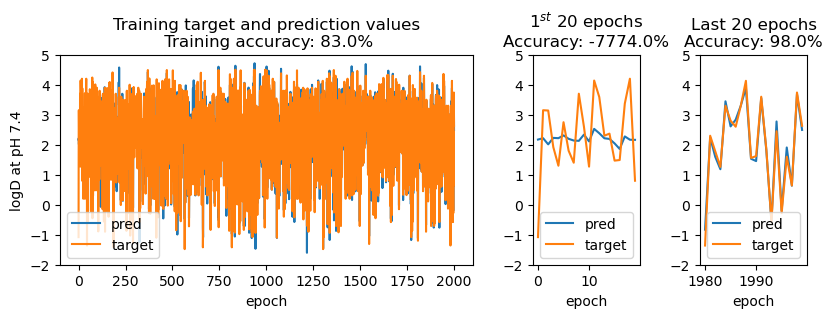

In [24]:
import matplotlib.pyplot as plt

# creating grid for subplots
fig = plt.figure(figsize=(10,6))
 
ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logD at pH 7.4', ax=ax1, ylim = (ymin, ymax) ) 
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ.png', bbox_inches='tight')

<div style="text-align:left;color:Maroon">
    <h4>More performance metrics.</h4>
</div>

<div style="text-align:left;color:Maroon">
    <h5>Plot RMSE (loss) and accuracy.</h5>
</div>
 

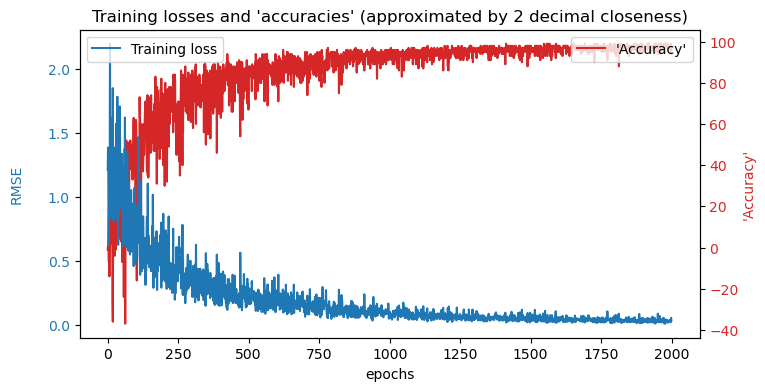

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx() 

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)  

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()
fig.savefig('assets/images/losses_and_accuracies.png', bbox_inches='tight')

<div style="text-align:center;color:Blue">
    <h3> Evaluate model: use test data</h3>
</div>

#### Now that the model is fully trained, a test data prediction can be performed to probe accuracy.
##### A few plots are shown below to help training and testing accuracy progression

In [26]:
import pandas as pd 

# One batch prediction
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()

,y,y_pred,real,pred
0,[2.430000066757202],[2.370570182800293],2.43,2.370570
1,[1.8300000429153442],[1.6375885009765625],1.83,1.637589
2,[1.909999966621399],[1.0188136100769043],1.91,1.018814
3,[2.1700000762939453],[2.1639938354492188],2.17,2.163994
4,[0.9800000190734863],[3.963179588317871],0.98,3.963180


In [27]:
test_acc = r2_accuracy(df["real"], df["pred"])
test_acc_1st_20 = r2_accuracy(df["real"][:20], df["pred"][:20])

print("Test accuracy is {}%".format(round(test_acc, 2) ))
print("1st 20 test accuracy is {}%".format(round(test_acc_1st_20, 2)))

Test accuracy is 45.0%
1st 20 test accuracy is 21.0%


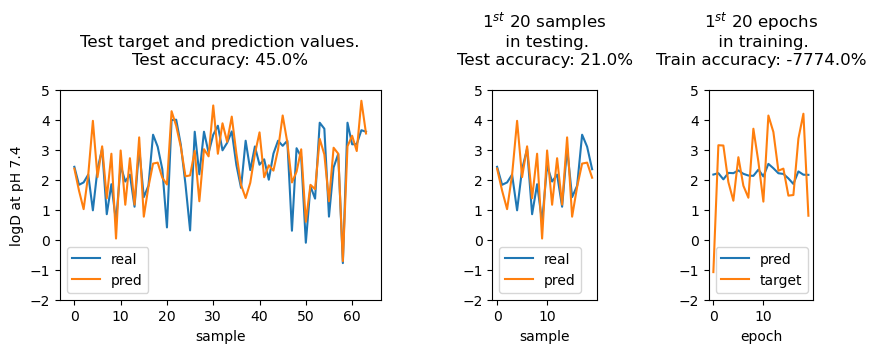

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,6))

ax1 = plt.subplot2grid(shape=(2, 36), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 36), loc=(0,20), colspan=5)
ax3 = plt.subplot2grid(shape=(2, 36), loc=(0,30), colspan=5)

test_title = "Test target and prediction values." + "\nTest accuracy: {}%\n".format(round(test_acc, 2))
df[["real", "pred"]].plot(title=test_title, xlabel='sample', ylabel = 'logD at pH 7.4',
                          ax=ax1, ylim = (ymin, ymax) ) 

test_title_1st_20 = "$1^{st}$ 20 samples\n in testing." + "\nTest accuracy: {}%\n".format(round(test_acc_1st_20, 2))  
df[["real", "pred"]][:20].plot(title=test_title_1st_20, xlabel='sample',
                                       ax=ax2, ylim = (ymin, ymax))

train_title = "$1^{st}$ 20 epochs\n in training." + "\nTrain accuracy: {}%\n".format(round(training_acc_1st_20,2))  
results[[ 'pred', 'target']][:20].plot(title=train_title,
                                       xlabel='epoch',
                                 # ylabel = 'logD at pH 7.4',
                                       ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ_trained.png', bbox_inches='tight')

### TO DO:
#### Note the low test accuracy value, which as mentioned before, could be due to over training (the last 20 samples during training were predicted at 98% accuracy). Try larger data for testing, smaller data and epochs for training